In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras import layers, models

# LEEMOS LOS DATOS

In [2]:
series = pd.read_csv('https://raw.githubusercontent.com/jorgesaenzdemiera/archivos/main/all_stocks_5yr.csv')
series.shape

(619040, 7)

In [3]:
series.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Dividimos los datos creando una serie para cada empresa

In [4]:
empresas = series.Name.unique()
len(empresas)

505

Hay 505 empresas distintas. (En verdad son 500 empresas, pero 5 de ellas tienen 2 tipos de acciones distintas, pero nosotros consideraremos 505 empresas distintas)

In [5]:
series_temporales = []
for empresa in empresas:
    serie = series[series.Name == empresa]
    if len(serie) == 1259:
        series_temporales.append(pd.Series(data = list(serie["close"]), index = list(serie["date"]), name = empresa))

In [6]:
len(series_temporales)

470

Hay un total de 35 empresas que no tienen todos los datos, no las tendremos en cuenta, quedandonos al final con 470 empresas

Vemos ahora de forma gráfica la primera serie temporal de nuestro conjunto:

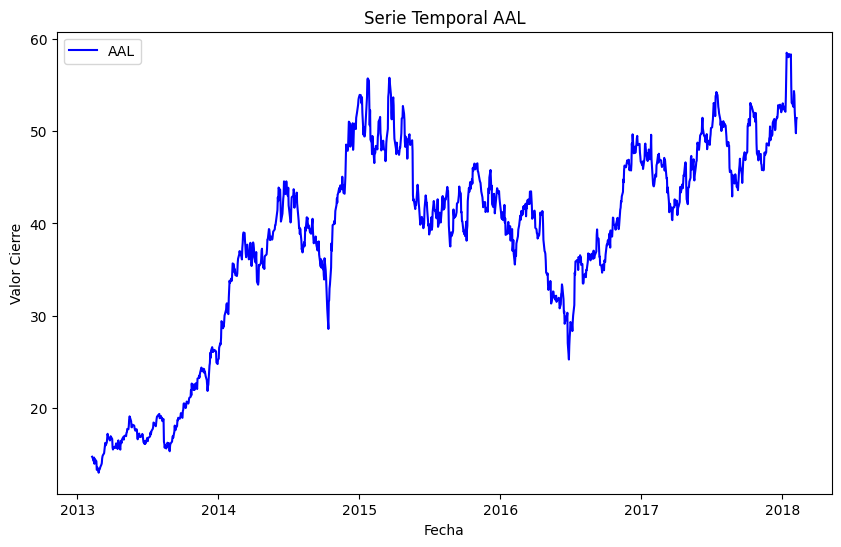

In [7]:
fechas = [datetime.strptime(fecha, '%Y-%m-%d') for fecha in series_temporales[0].index]
plt.figure(figsize=(10, 6))
plt.plot(fechas, series_temporales[0], label=series_temporales[0].name, color='blue')
plt.title('Serie Temporal AAL')
plt.xlabel('Fecha')
plt.ylabel('Valor Cierre')
plt.legend()
plt.show()

# PREPROCESAMOS LOS DATOS

## Dividimos en Train y test

In [8]:
series_temporales[0]

2013-02-08    14.75
2013-02-11    14.46
2013-02-12    14.27
2013-02-13    14.66
2013-02-14    13.99
              ...  
2018-02-01    53.88
2018-02-02    52.10
2018-02-05    49.76
2018-02-06    51.18
2018-02-07    51.40
Name: AAL, Length: 1259, dtype: float64

Vemos que los datos van desde el 8 de febrero de 2013 hasta el 7 de febrero de 2018, un total de 5 años. Antes de aplicar ninguna técnica de preprocesamiento, vamos a dividir nuestros datos en train y test. Para ello hemos decidido dejar el último año para test, lo que equivaldría a una separación 80% - 20%

In [9]:
indice_final_train = int(0.8*len(series_temporales[0]))

In [10]:
print(f' Cada serie temporal tiene un total de {len(series_temporales[0])} valores, de los cuales irán los primeros {int(len(series_temporales[0])*0.8)} para train, y los  {len(series_temporales[0]) - int(len(series_temporales[0])*0.8)} últimos para test. \nLa separación se establece en el día {series_temporales[0].index[indice_final_train]}')

 Cada serie temporal tiene un total de 1259 valores, de los cuales irán los primeros 1007 para train, y los  252 últimos para test. 
La separación se establece en el día 2017-02-08


En cada serie, se utilizaran los primeros 1007 valores para train, y los últimos 252 para test, lo que equivaldría a los datos entre el 8 de febrero de 2017 y el 7 de febrero de 2018, es decir, el último año

In [11]:
series_temporales_train = []
series_temporales_test = []
for serie in series_temporales:
    series_temporales_train.append(serie[:indice_final_train])
    series_temporales_test.append(serie[indice_final_train:])

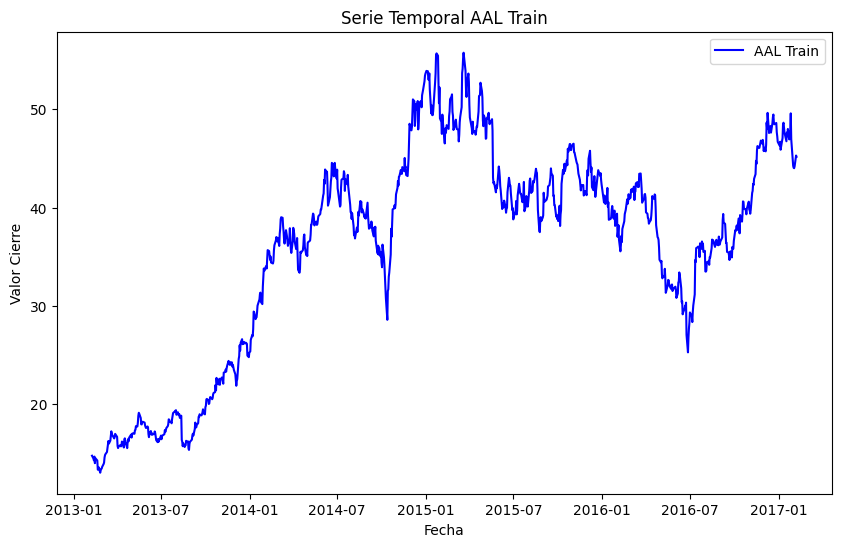

In [12]:
fechas_train = [datetime.strptime(fecha, '%Y-%m-%d') for fecha in series_temporales_train[0].index]
plt.figure(figsize=(10, 6))
plt.plot(fechas_train, series_temporales_train[0], label=f'{series_temporales_train[0].name} Train', color='blue')
plt.title('Serie Temporal AAL Train')
plt.xlabel('Fecha')
plt.ylabel('Valor Cierre')
plt.legend()
plt.show()

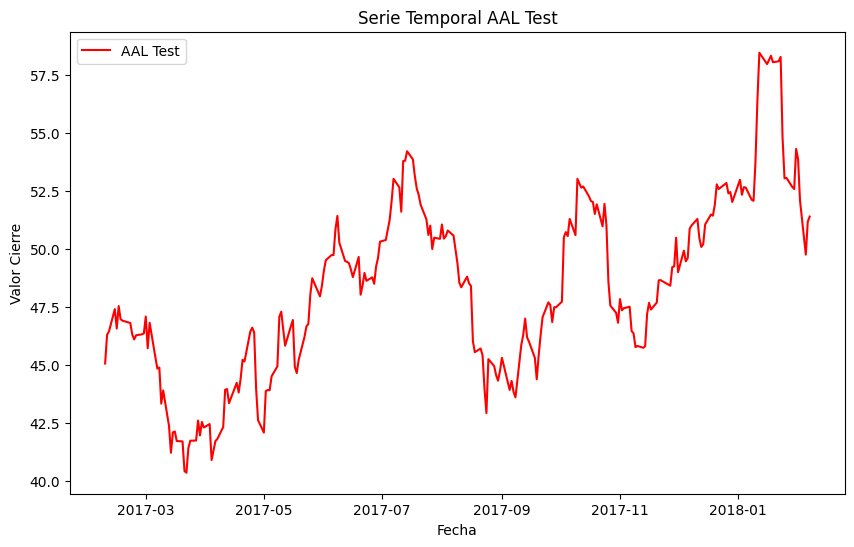

In [13]:
fechas_test = [datetime.strptime(fecha, '%Y-%m-%d') for fecha in series_temporales_test[0].index]
plt.figure(figsize=(10, 6))
plt.plot(fechas_test, series_temporales_test[0], label=f'{series_temporales_test[0].name} Test', color='red')
plt.title('Serie Temporal AAL Test')
plt.xlabel('Fecha')
plt.ylabel('Valor Cierre')
plt.legend()
plt.show()

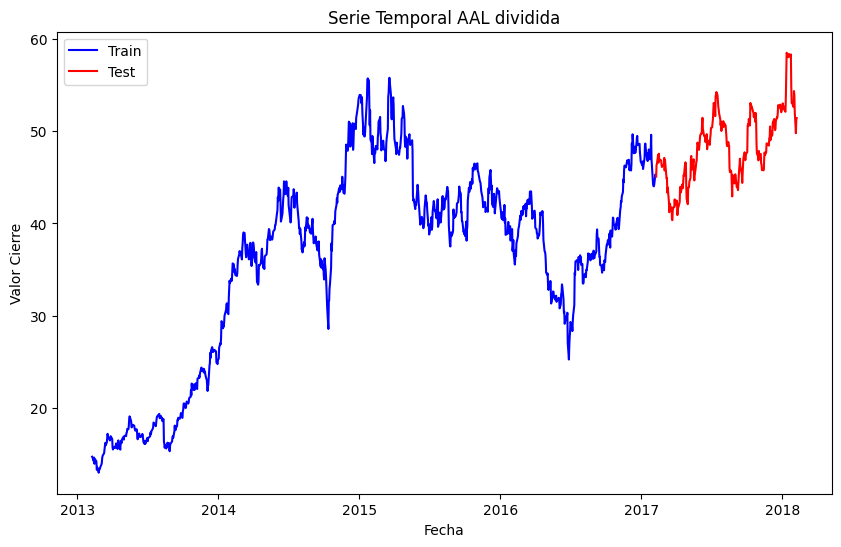

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(fechas_train, series_temporales_train[0], label='Train', color='blue')
plt.plot(fechas_test, series_temporales_test[0], label='Test', color='red')
plt.title('Serie Temporal AAL dividida')
plt.xlabel('Fecha')
plt.ylabel('Valor Cierre')
plt.legend()
plt.show()

Los datos de test los guardaremos para una evaluación final.

## Dividimos las series temporales en ventanas para entrenar a los modelos

Para entrenar a los modelos vamos a utilizar ventanas de la serie de train. En el caso de modelos de regresión, el objetivo a predecir será el siguiente valor de la ventana, y en el caso de clasificación, el objetivo a predecir será si el próximo valor va a subir o no con respecto al último valor de la ventana

In [15]:
def crear_ventanas_regresion(series, size, sep):
  ventanas =[]
  targets = []
  for serie in series:
    for i in range(0, len(serie) - size, sep):
      ventanas.append((serie[i:i + size]))
      targets.append(serie[i + size])
  return ventanas, targets

def crear_ventanas_clasificacion(series, size, sep):
  ventanas =[]
  targets = []
  for serie in series:
    for i in range(0, len(serie) - size, sep):
      ventanas.append((serie[i:i + size]))
      targets.append(serie[i + size] > serie[i + size - 1])
  return ventanas, targets

Además, como los datos de cada empresa son muy distintos, vamos a preparar funciones que creen ventanas como las anteriores pero normalizadas, y las correspondientes para desnormalizar

In [16]:
def crear_ventanas_regresion_norm(series, size, sep):
  ventanas =[]
  targets = []
  means = []
  stds = []
  for serie in series:
    for i in range(0, len(serie) - size, sep):
      mean = serie[i:i + size].mean()
      std = serie[i:i + size].std()
      means.append(mean)
      stds.append(std)
      ventanas.append((serie[i:i+size] - mean) / std)
      targets.append((serie[i + size] - mean) / std)
  return ventanas, targets, means, stds

def crear_ventanas_clasificacion_norm(series, size, sep):
  ventanas =[]
  targets = []
  means = []
  stds = []
  for serie in series:
    for i in range(0, len(serie) - size, sep):
      mean = serie[i:i + size].mean()
      std = serie[i:i + size].std()
      means.append(mean)
      stds.append(std)
      ventanas.append((serie[i:i+size] - mean) / std)
      targets.append(serie[i + size] > serie[i + size - 1])
  return ventanas, targets, means, stds

def desnormalizar(ventana, std, mean):
  return ventana * std + mean

In [17]:
X_y_regresion_series = crear_ventanas_regresion(series_temporales_train, 50, 40)
X_y_regresion_norm_series = crear_ventanas_regresion_norm(series_temporales_train, 50, 40)
X_y_clasificacion_series = crear_ventanas_clasificacion(series_temporales_train, 50, 40)
X_y_clasificacion_norm_series = crear_ventanas_clasificacion_norm(series_temporales_train, 50, 40)

Ya tenemos en cada caso una lista de series en la variable X, y una lista de valores en la variable y. Creamos ahora una función que prepara los datos para tenerlos en las dimensiones y tipo de datos adecuadoss para entrenar y evaluar los modelos.

In [18]:
def datos_para_modelos(X_y):
  X = np.array(X_y[0])
  y = np.array(X_y[1])
  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  return X, y

In [19]:
X_y_regresion = datos_para_modelos(X_y_regresion_series)
X_y_regresion_norm = datos_para_modelos(X_y_regresion_norm_series)
X_y_clasificacion = datos_para_modelos(X_y_clasificacion_series)
X_y_clasificacion_norm = datos_para_modelos(X_y_clasificacion_norm_series)

Dividimos ahora nuestros datos de Train en entrenamiento y validación, para poder evaluar los modelos. Como tenemos muchos datos, vamos a hacer una división del 90% de los datos de Train para entrenamiento, y el 10% para validación

In [20]:
def dividir_train_test(X_y, test_size):
  X_train, X_test = train_test_split(X_y[0], test_size=test_size)
  y_train, y_test = train_test_split(X_y[1], test_size=test_size)
  X_y_train = (X_train, y_train)
  X_y_test = (X_test, y_test)
  return X_y_train, X_y_test

In [21]:
X_y_train_regresion, X_y_test_regresion = dividir_train_test(X_y_regresion, 0.1)
X_y_train_regresion_norm, X_y_test_regresion_norm = dividir_train_test(X_y_regresion_norm, 0.1)
X_y_train_clasificacion, X_y_test_clasificacion = dividir_train_test(X_y_clasificacion, 0.1)
X_y_train_clasificacion_norm, X_y_test_clasificacion_norm = dividir_train_test(X_y_clasificacion_norm, 0.1)

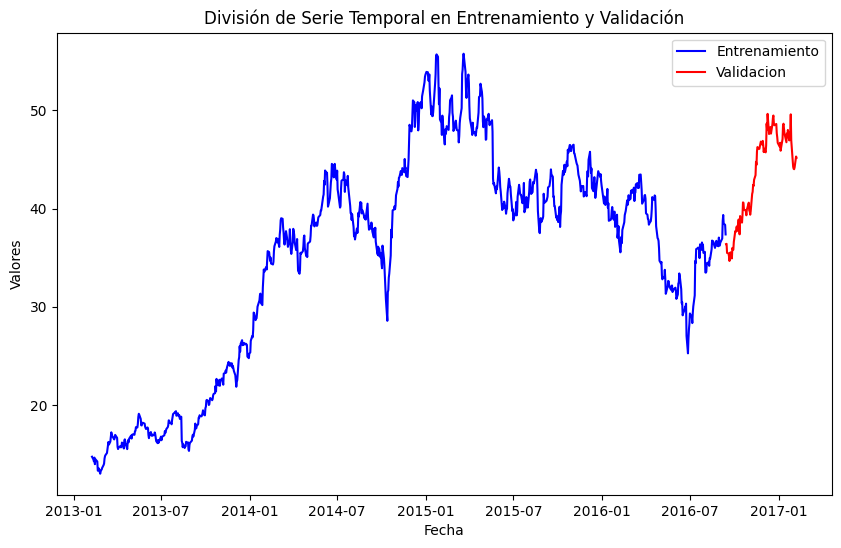

In [76]:
entrenamiento_size = int(len(series_temporales_train[0]) * 0.9)  # 90% para entrenamiento
entrenamiento, validacion = series_temporales_train[0][:entrenamiento_size], series_temporales_train[0][entrenamiento_size:]
fechas_entrenamiento, fechas_validacion = fechas_train[:entrenamiento_size], fechas_train[entrenamiento_size:]
plt.figure(figsize=(10, 6))
plt.plot(fechas_entrenamiento, entrenamiento.values, label='Entrenamiento', color='blue')
plt.plot(fechas_validacion, validacion.values, label='Validacion', color='red')

# Agregar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('División de Serie Temporal en Entrenamiento y Validación')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

# CREAMOS Y EVALUAMOS NUESTROS MODELOS

## Regresión

Para regresión vamos a crear dos modelos simples, uno de ellos con una red LSTM con la arquitectura más simple posible, con una sola cama LSTM y otra densa. El otro con arquitectura CNN, también con una sola capa convolucional, otra de pooling y 2 densas. cada una de estas arquitecturas la vamos a probar con datos normalizados y con no normalizados.

### LSTM

In [22]:
if os.path.exists("lstm.h5"):
  # Si el archivo existe, carga el modelo desde el archivo
  lstm = load_model("lstm.h5")
else:
  lstm = Sequential()
  lstm.add(LSTM(50, input_shape=(X_y_train_regresion[0].shape[1], 1)))
  lstm.add(Dense(1))
  lstm.compile(optimizer='adam', loss='mse')
  lstm.fit(X_y_train_regresion[0], X_y_train_regresion[1], epochs=50, batch_size=32, verbose = 0)
  lstm.save('lstm.h5')

Tiempo de ejecución: 6 minutos 12 segundos

In [23]:
if os.path.exists("lstm_norm.h5"):
  # Si el archivo existe, carga el modelo desde el archivo
  lstm_norm = load_model("lstm_norm.h5")
else:
  lstm_norm = Sequential()
  lstm_norm.add(LSTM(50, input_shape=(X_y_train_regresion_norm[0].shape[1], 1)))
  lstm_norm.add(Dense(1))
  lstm_norm.compile(optimizer='adam', loss='mse')
  lstm_norm.fit(X_y_train_regresion_norm[0], X_y_train_regresion_norm[1], epochs=50, batch_size=32, verbose = 0)
  lstm_norm.save('lstm_norm.h5')


Tiempo de ejecución: 5 minutos 24 segundos

### CNN

In [24]:
if os.path.exists('cnn.h5'):
  # Si el archivo existe, carga el modelo desde el archivo
  cnn = load_model('cnn.h5')
else:
  cnn = Sequential()
  cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_y_train_regresion[0].shape[1], 1)))
  cnn.add(MaxPooling1D(pool_size=2))
  cnn.add(Flatten())
  cnn.add(Dense(50, activation='relu'))
  cnn.add(Dense(1))
  cnn.compile(optimizer='adam', loss='mse')
  cnn.fit(X_y_train_regresion[0], X_y_train_regresion[1], epochs=50, batch_size=32, verbose = 0)
  cnn.save('cnn.h5')

Tiempo de ejecución: 1 minuto 10 segundos

In [25]:
if os.path.exists('cnn_norm.h5'):
  # Si el archivo existe, carga el modelo desde el archivo
  cnn_norm = load_model('cnn_norm.h5')
else:
  cnn_norm = Sequential()
  cnn_norm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_y_train_regresion_norm[0].shape[1], 1)))
  cnn_norm.add(MaxPooling1D(pool_size=2))
  cnn_norm.add(Flatten())
  cnn_norm.add(Dense(50, activation='relu'))
  cnn_norm.add(Dense(1))
  cnn_norm.compile(optimizer='adam', loss='mse')
  cnn_norm.fit(X_y_train_regresion_norm[0], X_y_train_regresion_norm[1], epochs=50, batch_size=32, verbose = 0)
  cnn_norm.save('cnn_norm.h5')

Tiempo de ejecución: 1 minuto 13 segundos

Realizamos las predicciones en nuestro conjunto de validación

In [26]:
y_pred_lstm = lstm.predict(X_y_test_regresion[0])
y_pred_lstm_norm = lstm_norm.predict(X_y_test_regresion_norm[0])
y_pred_cnn = cnn.predict(X_y_test_regresion[0])
y_pred_cnn_norm = cnn_norm.predict(X_y_test_regresion_norm[0])

36/36 [==============================] - 0s 3ms/step


In [27]:
y_pred_lstm

array([[79.41243 ],
       [79.422195],
       [79.29754 ],
       ...,
       [79.41792 ],
       [79.4222  ],
       [79.40178 ]], dtype=float32)

In [28]:
X_y_test_regresion[1]

array([ 62.58,  81.05, 158.05, ...,  48.71,  60.94,  45.56])

Vamos a ver los resultados

In [29]:
print("\033[1m" + "Errores LSTM:" + "\033[0m")
mse = mean_squared_error(X_y_test_regresion[1], y_pred_lstm)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(X_y_test_regresion[1], y_pred_lstm)
print(f'Mean Absolute Error (MAE): {mae}')
r2 = r2_score(X_y_test_regresion[1], y_pred_lstm)
print(f'R-squared (R^2): {r2}')

Errores LSTM:
Mean Squared Error (MSE): 5285.685867380967
Root Mean Squared Error (RMSE): 72.70272255824376
Mean Absolute Error (MAE): 42.44203782650562
R-squared (R^2): -0.0009161784221438651


In [30]:
print("\033[1m" + "Errores LSTM normalizado:" + "\033[0m")
mse = mean_squared_error(X_y_test_regresion_norm[1], y_pred_lstm_norm)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(X_y_test_regresion_norm[1], y_pred_lstm_norm)
print(f'Mean Absolute Error (MAE): {mae}')
r2 = r2_score(X_y_test_regresion_norm[1], y_pred_lstm_norm)
print(f'R-squared (R^2): {r2}')

Errores LSTM normalizado:
Mean Squared Error (MSE): 1.9194819398985068
Root Mean Squared Error (RMSE): 1.3854536946063938
Mean Absolute Error (MAE): 1.1460735245726685
R-squared (R^2): -0.002151277675724206


In [31]:
print("\033[1m" + "Errores CNN:" + "\033[0m")
mse = mean_squared_error(X_y_test_regresion[1], y_pred_cnn)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(X_y_test_regresion[1], y_pred_cnn)
print(f'Mean Absolute Error (MAE): {mae}')
r2 = r2_score(X_y_test_regresion[1], y_pred_cnn)
print(f'R-squared (R^2): {r2}')

Errores CNN:
Mean Squared Error (MSE): 5375.196613409153
Root Mean Squared Error (RMSE): 73.31573237313498
Mean Absolute Error (MAE): 45.139739951351515
R-squared (R^2): -0.017866250009852536


In [32]:
print("\033[1m" + "Errores CNN normalizado:" + "\033[0m")
mse = mean_squared_error(X_y_test_regresion_norm[1], y_pred_cnn_norm)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(X_y_test_regresion_norm[1], y_pred_cnn_norm)
print(f'Mean Absolute Error (MAE): {mae}')
r2 = r2_score(X_y_test_regresion_norm[1], y_pred_cnn_norm)
print(f'R-squared (R^2): {r2}')

Errores CNN normalizado:
Mean Squared Error (MSE): 3.1487324161285146
Root Mean Squared Error (RMSE): 1.7744667976968502
Mean Absolute Error (MAE): 1.41898002072764
R-squared (R^2): -0.6439363915291689


...

## Clasificación

Para la clasificación vamos a utilizar redes neuronales convolucionales, que funcionan muy bien encontrando patrones en imágenes. Para aprovechar al máximo su potencial, vamos a hacer una transformación de nuestras series temporales a imágenes

### Conversión a imágenes

Para convertir las series temporales a imágenes vamos a utilizar el método de Gramian Angular Field (GAF) y el de Markov Transition Field (MTF)

#### GAF

In [35]:
pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.9 MB/s eta 0:00:00


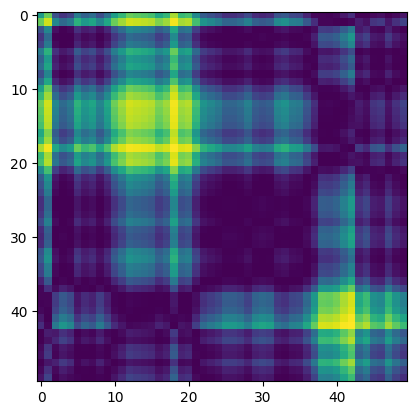

In [36]:
from pyts.image import GramianAngularField
import matplotlib.pyplot as plt
window_size = 50
X_train_im = X_y_train_clasificacion[0].reshape((X_y_train_clasificacion[0].shape[0], X_y_train_clasificacion[0].shape[1]))
X_test_im = X_y_test_clasificacion[0].reshape((X_y_test_clasificacion[0].shape[0], X_y_test_clasificacion[0].shape[1]))

gaf = GramianAngularField(image_size=window_size)
gaf_train = gaf.fit_transform(X_train_im)
gaf_test = gaf.transform(X_test_im)

# plot one image
plt.imshow(gaf_train[0])
plt.show()

#### MTF

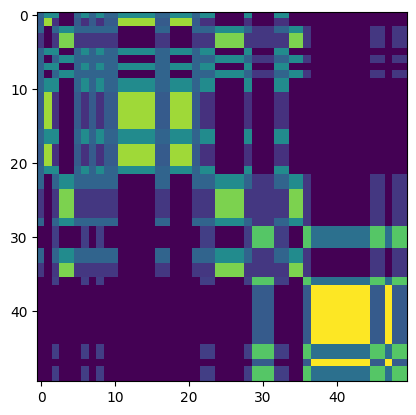

In [37]:
from pyts.image import MarkovTransitionField
import matplotlib.pyplot as plt


mtf = MarkovTransitionField(image_size=window_size, n_bins=6)
mtf_train = mtf.fit_transform(X_train_im)
mtf_test = mtf.transform(X_test_im)

# plot one image
plt.imshow(mtf_train[0])
plt.show()

### Aplicamos CNN a las imágenes

Aplicamos CNN a las imágenes obtenidas mediante GAF:

In [78]:
if os.path.exists('cnn_gaf.h5'):
  # Si el archivo existe, carga el modelo desde el archivo
  cnn_gaf = load_model('cnn_gaf.h5')
else:
  # Agregar una dimensión para los canales (1 canal en escala de grises)
  im_train = np.expand_dims(gaf_train, axis=-1)

  # Crear el modelo CNN
  cnn_gaf = models.Sequential()
  cnn_gaf.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(window_size, window_size, 1)))
  cnn_gaf.add(layers.MaxPooling2D((2, 2)))
  cnn_gaf.add(layers.Conv2D(64, (3, 3), activation='relu'))
  cnn_gaf.add(layers.MaxPooling2D((2, 2)))
  cnn_gaf.add(layers.Conv2D(64, (3, 3), activation='relu'))

  cnn_gaf.add(layers.Flatten())
  cnn_gaf.add(layers.Dense(64, activation='relu'))
  cnn_gaf.add(layers.Dense(1, activation='sigmoid'))

  # Compilar el modelo
  cnn_gaf.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Entrenar el modelo
  cnn_gaf_history = cnn_gaf.fit(gaf_train, X_y_train_clasificacion[1], epochs=15, batch_size=128, validation_split=0.2, verbose=1) # Unos 6 minutos
  cnn_gaf.save('cnn_gaf.h5')

Epoch 1/15
64/64 [==============================] - 34s 489ms/step - loss: 0.6840 - accuracy: 0.5748 - val_loss: 0.6837 - val_accuracy: 0.5711
Epoch 2/15
64/64 [==============================] - 30s 462ms/step - loss: 0.6818 - accuracy: 0.5770 - val_loss: 0.6844 - val_accuracy: 0.5711
Epoch 3/15
64/64 [==============================] - 29s 453ms/step - loss: 0.6828 - accuracy: 0.5770 - val_loss: 0.6842 - val_accuracy: 0.5711
Epoch 4/15
64/64 [==============================] - 32s 497ms/step - loss: 0.6801 - accuracy: 0.5779 - val_loss: 0.6893 - val_accuracy: 0.5711
Epoch 5/15
64/64 [==============================] - 29s 453ms/step - loss: 0.6804 - accuracy: 0.5774 - val_loss: 0.6841 - val_accuracy: 0.5711
Epoch 6/15
64/64 [==============================] - 29s 459ms/step - loss: 0.6786 - accuracy: 0.5780 - val_loss: 0.6838 - val_accuracy: 0.5711
Epoch 7/15
64/64 [==============================] - 30s 466ms/step - loss: 0.6770 - accuracy: 0.5776 - val_loss: 0.6838 - val_accuracy: 0.5677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ahora aplicamos el mismo modelo CNN a las imágenes obtenidas mediante MTF:

In [39]:
if os.path.exists('cnn_mtf.h5'):
  # Si el archivo existe, carga el modelo desde el archivo
  cnn_gaf = load_model('cnn_mtf.h5')
else:
  # Agregar una dimensión para los canales (1 canal en escala de grises)
  im_train = np.expand_dims(mtf_train, axis=-1)

  # Crear el modelo CNN
  cnn_mtf = models.Sequential()
  cnn_mtf.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(window_size, window_size, 1)))
  cnn_mtf.add(layers.MaxPooling2D((2, 2)))
  cnn_mtf.add(layers.Conv2D(64, (3, 3), activation='relu'))
  cnn_mtf.add(layers.MaxPooling2D((2, 2)))
  cnn_mtf.add(layers.Conv2D(64, (3, 3), activation='relu'))

  cnn_mtf.add(layers.Flatten())
  cnn_mtf.add(layers.Dense(64, activation='relu'))
  cnn_mtf.add(layers.Dense(1, activation='sigmoid'))

  # Compilar el modelo
  cnn_mtf.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # Entrenar el modelo
  cnn_mtf_history = cnn_mtf.fit(mtf_train, X_y_train_clasificacion[1], epochs=15, batch_size=128, validation_split=0.2, verbose=1) # Unos 7 minutos
  cnn_mtf.save('cnn_mtf.h5')

Epoch 1/15
64/64 [==============================] - 31s 470ms/step - loss: 0.6832 - accuracy: 0.5769 - val_loss: 0.6832 - val_accuracy: 0.5711
Epoch 2/15
64/64 [==============================] - 29s 461ms/step - loss: 0.6814 - accuracy: 0.5770 - val_loss: 0.6831 - val_accuracy: 0.5711
Epoch 3/15
64/64 [==============================] - 28s 444ms/step - loss: 0.6814 - accuracy: 0.5770 - val_loss: 0.6889 - val_accuracy: 0.5711
Epoch 4/15
64/64 [==============================] - 29s 460ms/step - loss: 0.6801 - accuracy: 0.5770 - val_loss: 0.6836 - val_accuracy: 0.5711
Epoch 5/15
64/64 [==============================] - 29s 462ms/step - loss: 0.6786 - accuracy: 0.5770 - val_loss: 0.6835 - val_accuracy: 0.5711
Epoch 6/15
64/64 [==============================] - 30s 464ms/step - loss: 0.6752 - accuracy: 0.5786 - val_loss: 0.6856 - val_accuracy: 0.5711
Epoch 7/15
64/64 [==============================] - 29s 451ms/step - loss: 0.6678 - accuracy: 0.5893 - val_loss: 0.6875 - val_accuracy: 0.5608

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluamos ahora los modelos con los datos de validación:

Primero vemos los resultados de aplicar CNN a imágenes obtenidas mediante GAF

In [40]:
def mostrar_loss_accuracy(modelo_history):
  train_loss = modelo_history.history['loss']
  val_loss = modelo_history.history['val_loss']
  train_accuracy = modelo_history.history['accuracy']
  val_accuracy = modelo_history.history['val_accuracy']

  # Crear gráficos de pérdida
  plt.figure(figsize=(12, 4))

  # Gráfico de pérdida
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Gráfico de precisión
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Mostrar los gráficos
  plt.tight_layout()
  plt.show()


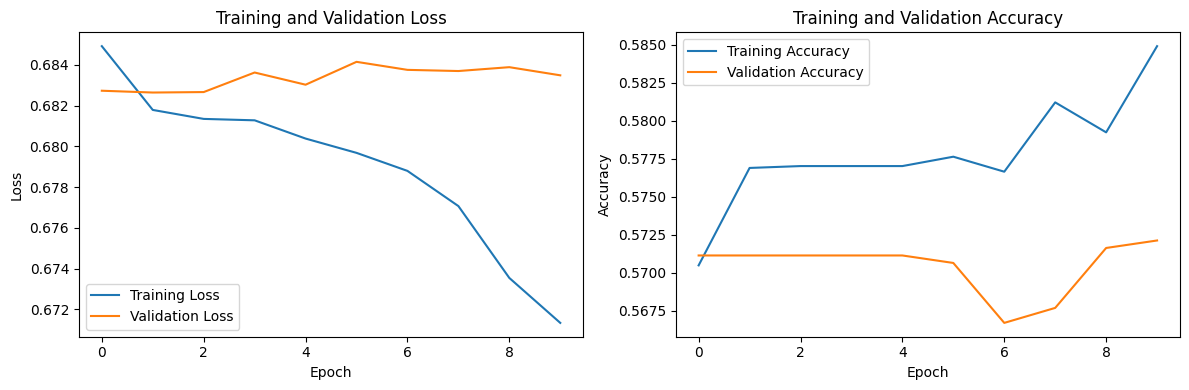

In [77]:
mostrar_loss_accuracy(cnn_gaf_history)

In [42]:
preds_gaf = cnn_gaf.predict(gaf_test)
preds_gaf = (preds_gaf > 0.5).astype(int)
print('---------------------------Confusion Matrix---------------------\n')
print(classification_report(X_y_test_clasificacion[1], preds_gaf))

36/36 [==============================] - 1s 33ms/step
---------------------------Confusion Matrix---------------------

              precision    recall  f1-score   support

       False       0.58      0.95      0.72       654
        True       0.48      0.06      0.11       474

    accuracy                           0.58      1128
   macro avg       0.53      0.51      0.41      1128
weighted avg       0.54      0.58      0.46      1128



Y ahora echamos un vistazo a los resultados de la clasificación mediante una CNN usando imágenes obtenidas con MTF a partir de nuestras series temporales originales

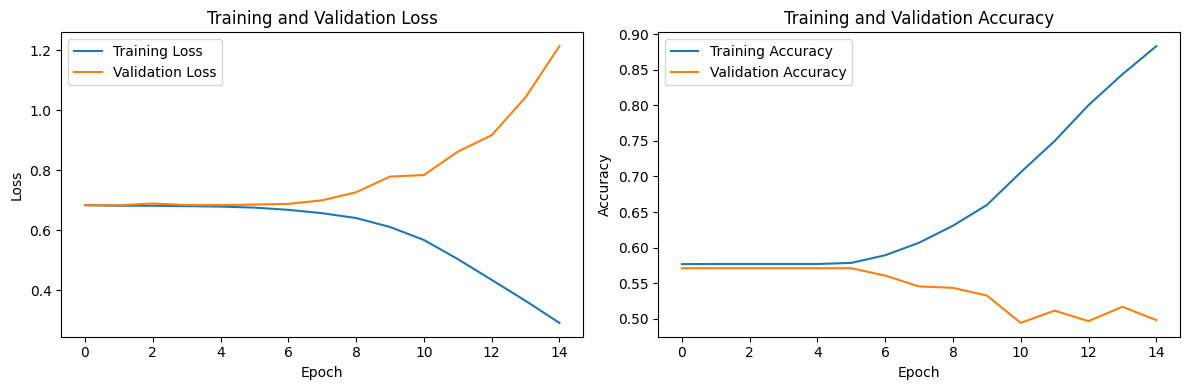

In [43]:
mostrar_loss_accuracy(cnn_mtf_history)

In [44]:
preds_mtf = cnn_mtf.predict(mtf_test)
preds_mtf = (preds_mtf > 0.5).astype(int)
print('---------------------------Confusion Matrix---------------------\n')
print(classification_report(X_y_test_clasificacion[1], preds_mtf))

36/36 [==============================] - 1s 26ms/step
---------------------------Confusion Matrix---------------------

              precision    recall  f1-score   support

       False       0.59      0.62      0.61       654
        True       0.44      0.41      0.43       474

    accuracy                           0.54      1128
   macro avg       0.52      0.52      0.52      1128
weighted avg       0.53      0.54      0.53      1128



# VEMOS PUESTA EN PRÁCTICA CON DATOS DE TEST

Creamos una función que recibe las series temporales, tanto de entrenamiento como de test, una función "predecir", que decidirá cada día, de qué empresas se deben comprar acciones, y un entero n, que establece el tamaño de la ventana que se enviará a la función predecir.

In [45]:
def evolucion(series_temporales_train, series_temporales_test, predecir, n):

  inversion = []
  ventas = []
  empresas_inv = []

  X_pred = []
  for serie in series_temporales_train:
    X_pred.append(serie.tail(n))

  empresas_pred = []
  for ventana in X_pred:
    if predecir(ventana):
      empresas_pred.append(ventana.name)
  empresas_inv.append(empresas_pred)

  inv = 0
  for serie in series_temporales_train:
    if serie.name in empresas_pred:
        inv += serie[-1]
  inversion.append(inv)

  for id in range(len(series_temporales_test[0])):

    venta = 0
    for serie in series_temporales_test:
      if serie.name in empresas_pred:
        venta += serie[id]
    ventas.append(venta)

    for i in range(len(X_pred)):
      nombre = X_pred[i].name
      X_pred[i] = pd.concat([X_pred[i].iloc[1:], pd.Series(series_temporales_test[i][id], index = [series_temporales_test[i].index[id]])])
      X_pred[i].name = nombre
    empresas_pred = []
    for ventana in X_pred:
      if predecir(ventana):
        empresas_pred.append(ventana.name)
    empresas_inv.append(empresas_pred)

    inv = 0
    for serie in series_temporales_test:
        if serie.name in empresas_pred:
            inv += serie[id]
    inversion.append(inv)

  return inversion, ventas, empresas_inv

Como vemos, para cada día del último año que habíamos guardado para test, y para cada acción, se envía a la función predecir una ventana con los n últimos datos de esa acción. Esta acción devolverá un valor booleano, que predice si la acción va a subir al día siguiente o no, y por tanto, decidirá si se debe comprar una acción de esa empresa ese día o no. Estas empresas, que se ha predicho que van a subir se almacenan en empresas_pred, y se simula que se compra una acción de cada una de ellas, almacenándose en la lista inversión el coste total de todas las acciones. Luego se almacena en la lista ventas el coste de esas mismas acciones en el día siguiente, simulandose así, que vendemos todas aquellas acciones que habíamos comprado el día anterior. Este proceso se repite cada día del año que habíamos reservado para test.

Para tener una base, vamos a crear una función que clasifica en comprar - no comprar de manera aleatoria

In [46]:
def predecir_aleatorio(ventana):
  return random.choice([True, False])

Vemos como funcionaría para nuestros datos (nos fijamos que en este caso, n puede ser cualquier número, ya que da igual cuantos datos contenga la ventana, porque no se van a usar):

In [47]:
inversion, ventas, empresas_inv = evolucion(series_temporales_train, series_temporales_test, predecir_aleatorio, 1)

Para ver los resultados, vamos a crear unas funciones que cree un reporte con la información más importante y nos permitan ver gráficamente el beneficio que obtenemos.

In [48]:
def generar_reporte(inversion, ventas, empresas_inv):
  balance = [ganancia - inversion[i] for i, ganancia in enumerate(ventas)]
  total_acciones = 0
  for empresas in empresas_inv:
    total_acciones += len(empresas)
  media_acciones = total_acciones/len(inversion)
  reporte = print(f'El balance final es de {round(sum(balance), 2)} $\nCon una inversión total de {round(sum(inversion), 2)} $ \nEl día con la mayor inversión fueron {round(max(inversion), 2)} $\nEl día con mayor beneficio fueron {round(max(balance), 2)} $, \nEl día con mayores pérdidas fueron {round(min(balance), 2)} $, \nSe han comprado un total de {total_acciones} acciones, con una media de {round(media_acciones, 2)} por día')
  evolucion_balance = calcular_evolucion_balance(balance)
  plt.figure(figsize=(10, 6))
  plt.title("Evolución del balance")
  plt.plot(fechas_test, evolucion_balance)

In [49]:
def calcular_evolucion_balance(balance):
  acumulador = 0
  evolucion_balance = []
  for b in balance:
    evolucion_balance.append(b + acumulador)
    acumulador += b
  return evolucion_balance

Hay que eliminar el último valor de inversiones y de empresas que corresponden a la prediccion del día siguiente al último del que tenemos datos

El balance final es de 3743.25 $
Con una inversión total de 6055074.67 $ 
El día con la mayor inversión fueron 29928.24 $
El día con mayor beneficio fueron 390.21 $, 
El día con mayores pérdidas fueron -908.69 $, 
Se han comprado un total de 59314 acciones, con una media de 235.37 por día


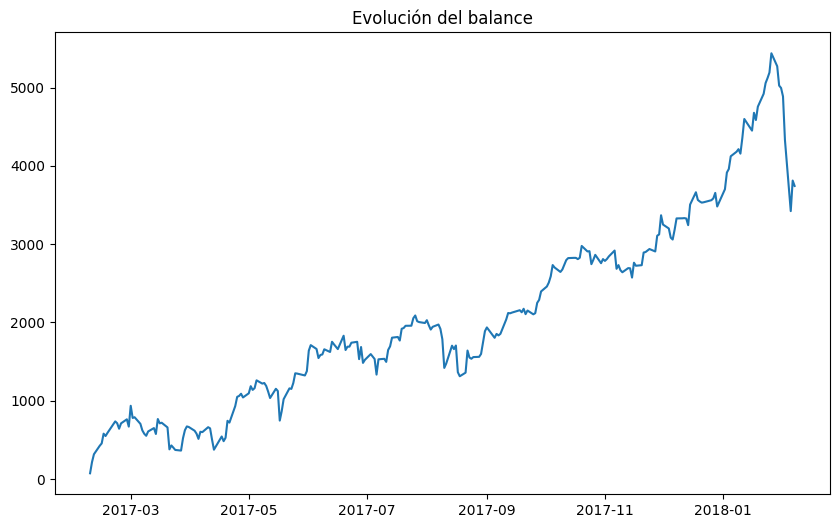

In [50]:
inversion = inversion[:-1]
empresas_inv = empresas_inv[:-1]
generar_reporte(inversion, ventas, empresas_inv)

Vemos que con una clasificación aleatoria obtendríamos un beneficio a lo largo del año de unos 3600 $. Vamos a utilizar esta predicción como baseline para evaluar los modelos que hemos visto previamente. Obtener beneficios de esta manera, puede ser porque el año en el que estamos haciendo estas comprobaciones, ha sido en general bueno para todas las empresas del índice, y por eso, comprando cada día las acciones que fuesen, vamos a obtener beneficios al final del año. También debemos tener en cuenta que estamos considerando una compra sin comisiones. Lo más normal en el mundo real es que haya un porcentaje de comisión que reduce considerablemente estos beneficios.

Para comprobar que los resultados obtenidos con el clasificador aleatorio son coherentes, vamos a probar también qué sucedería si nuestro clasificador clasifica todas las empresas siempre como que van a subir.

In [51]:
def predecir_todas(ventana):
  return True

El balance final es de 7506.39 $
Con una inversión total de 12104427.01 $ 
El día con la mayor inversión fueron 54997.28 $
El día con mayor beneficio fueron 739.55 $, 
El día con mayores pérdidas fueron -1938.37 $, 
Se han comprado un total de 118440 acciones, con una media de 470.0 por día


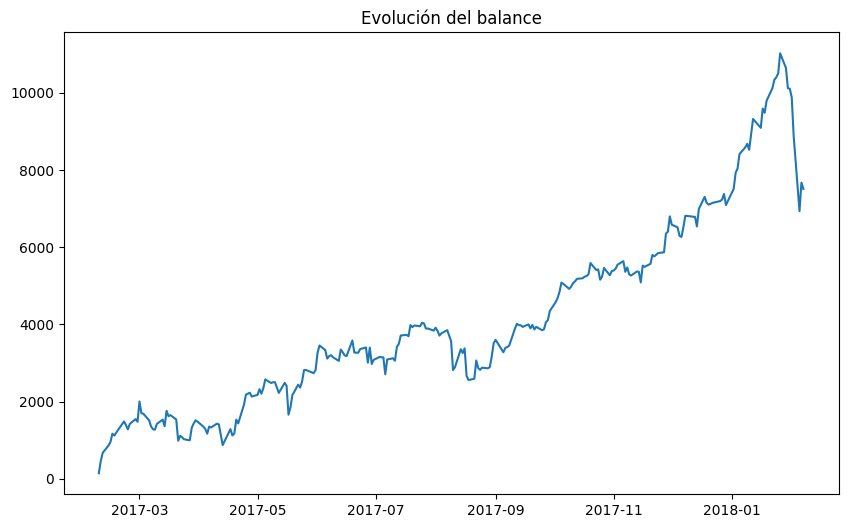

In [52]:
inversion, ventas, empresas_inv = evolucion(series_temporales_train, series_temporales_test, predecir_todas, 1)
inversion = inversion[:-1]
empresas_inv = empresas_inv[:-1]
generar_reporte(inversion, ventas, empresas_inv)

Efectivamente vemos que al comprar todas las acciones todos los días se consigue un resultado muy pareccido, incluso con un beneficio mayor. Esto puede resultar engañoso, ya que, lo único que estamos haciendo con respecto al caso anterior es aumentar todos los valores de los resultados obtenidos. Con una buena predicción no solo queremos maximizar el balance final que tenemos, sino que queremos hacerlo invirtiendo la menor cantidad posible. En concreto, el valor de día con la mayor inversión, quiere decir que necesitamos tener disponible en un día esa cantidad de dinero, y en este último caso son 55.000 $, un gasto para un único día irreal. Para futuras evaluaciones, vamos a fijarnos en el valor (balance final)/(maxima inversion en un día), que en los dos casos probados es similar, 0.13

## Vemos nuestros mejores modelos

### CNN con MTF

In [53]:
def predecir_cnn_mtf(ventana):
  X = mtf.transform(np.array([ventana]))
  pred = cnn_mtf.predict(X, verbose = 0)
  sube = (pred > 0.5).astype(int)
  return sube

In [81]:
inversion, ventas, empresas_inv = evolucion(series_temporales_train, series_temporales_test, predecir_cnn_mtf, 50) # Una hora y media de ejecución
inversion = inversion[:-1]
empresas_inv = empresas_inv[:-1]
generar_reporte(inversion, ventas, empresas_inv)

### CNN con GAF

In [84]:
def predecir_cnn_gaf(ventana):
  X = gaf.transform(np.array([ventana]))
  pred = cnn_gaf.predict(X, verbose = 0)
  sube = (pred > 0.5).astype(int)
  return sube

In [83]:
inversion, ventas, empresas_inv = evolucion(series_temporales_train, series_temporales_test, predecir_cnn_gaf, 50)
inversion = inversion[:-1]
empresas_inv = empresas_inv[:-1]
generar_reporte(inversion, ventas, empresas_inv)

Para probar si podemos mejorar el azar, fuera de los modelos propuestos, vamos a probar a usar otro tipo de reglas sencillas para predecir si una serie va a subir o no.
La primera que hemos implementado, se basa en la tendencia, si la ventana a analizar, presenta una tendencia alcista, se predice que esta acción puede seguir subiendo, y se simula su compra


In [79]:
def predecir_tendencia(subserie):
  return subserie[-1] > subserie[0]

El balance final es de 4711.4 $
Con una inversión total de 7367441.76 $ 
El día con la mayor inversión fueron 45758.27 $
El día con mayor beneficio fueron 436.04 $, 
El día con mayores pérdidas fueron -512.46 $, 
Se han comprado un total de 68772 acciones, con una media de 272.9 por día


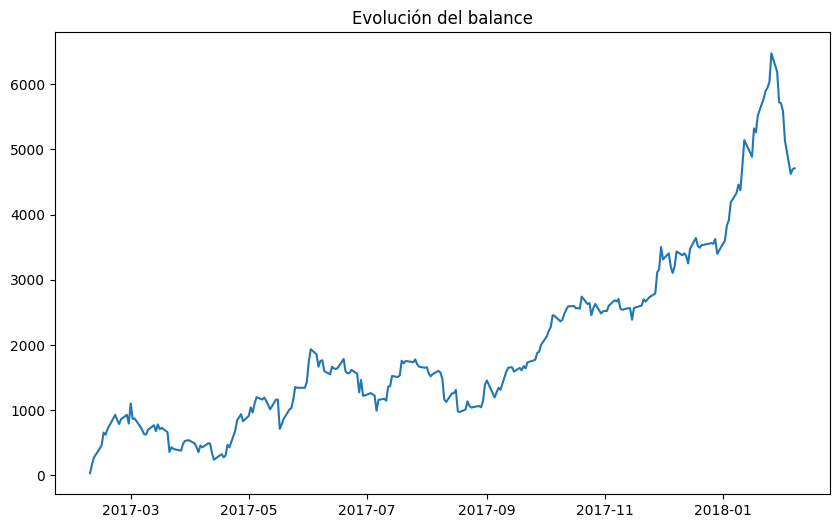

In [80]:
inversion, ventas, empresas_inv = evolucion(series_temporales_train, series_temporales_test, predecir_tendencia, 10)
inversion = inversion[:-1]
empresas_inv = empresas_inv[:-1]
generar_reporte(inversion, ventas, empresas_inv)